<a href="https://colab.research.google.com/github/WilderJoseth/datascience/blob/master/statistics/projects/python/New_York_City_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York City Taxi Fare Prediction

Author: Wilder R.

Date: 17/09/2020



# Table of contents

### 1. Introduction

### 2. Methodology
* 2.1. Business Understanding
* 2.2. Data Understanding
* 2.3. Data Preparation
* 2.4. Modeling
* 2.5. Evaluation
* 2.6. Deployment

### 3. Results

### 4. Conclusions

### 5. References

# 1. Introduction

One of the most important thing in Data Science training is to make projects applying gained skills.

In this case, I will create a project to predict rider's taxi fare, which is a competition of Kaggle (https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview). For this project, I will apply my Data Science skills gained thanks IBM Data Science Certificado profesional of Coursera.

For this project, I will apply the following topics:

1. Frequentist statistics to understand the data.
2. TensorFlow to process data and create the model.

# 2. Methodology
This project will be created using CRISP-DM methodology.
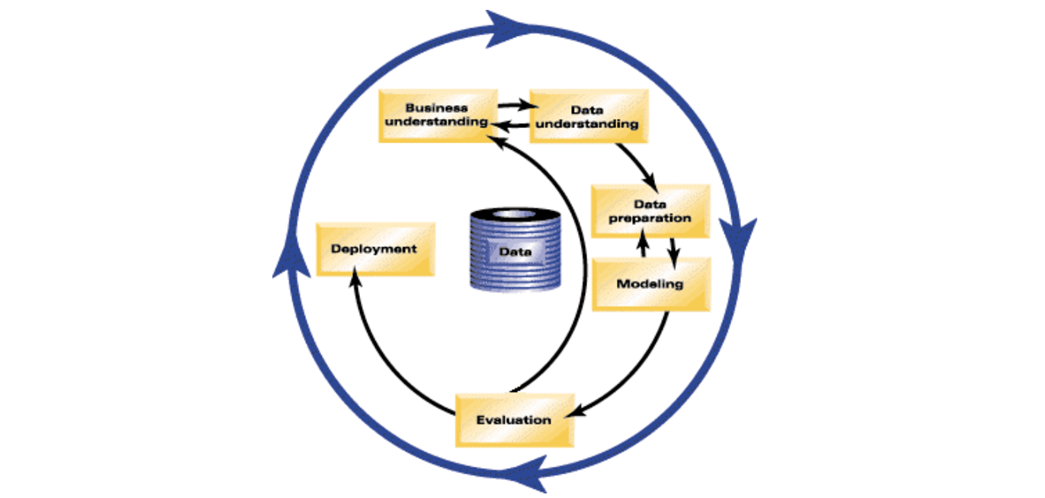

## 2.1. Business Understanding

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

 99% 1.55G/1.56G [00:16<00:00, 52.5MB/s]
100% 1.56G/1.56G [00:17<00:00, 98.3MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 134MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 104MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 413kB/s]


In [ ]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
pathTestData = '/content/test.csv'
pathTrainData = '/content/train.csv'

In [ ]:
!head {pathTrainData}

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

In [ ]:
# Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(tf.__version__)

2.3.0


In [ ]:
# Hyperparameters
batchSize = 8
R = 6373.0 # kilometros
seed = 1

In [ ]:
def getDataSet(file_pattern, batch_size, label_name, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_pattern = file_pattern,
      batch_size = batch_size, # Artificially small to make examples easier to show.
      label_name = label_name,
      na_value = '?',
      num_epochs = 1,
      ignore_errors = True, 
      **kwargs)
  return dataset

In [ ]:
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

In [ ]:
rawTrainData = getDataSet(pathTrainData, batchSize, 'fare_amount', shuffle_seed = seed)

In [ ]:
rawTrainData

<PrefetchDataset shapes: (OrderedDict([(key, (None,)), (pickup_datetime, (None,)), (pickup_longitude, (None,)), (pickup_latitude, (None,)), (dropoff_longitude, (None,)), (dropoff_latitude, (None,)), (passenger_count, (None,))]), (None,)), types: (OrderedDict([(key, tf.string), (pickup_datetime, tf.string), (pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.int32)]), tf.float32)>

## Transformations

In [ ]:
for element in rawTrainData.take(3).as_numpy_iterator():
  print(element)

(OrderedDict([('key', array([b'2013-11-10 21:10:00.000000104', b'2014-08-05 01:05:37.0000001',
       b'2009-02-13 16:54:52.0000006', b'2010-02-26 19:08:56.0000002',
       b'2011-03-08 09:40:20.0000002', b'2013-10-15 11:36:18.0000001',
       b'2009-06-04 03:44:00.0000008', b'2015-02-01 08:46:57.0000002'],
      dtype=object)), ('pickup_datetime', array([b'2013-11-10 21:10:00 UTC', b'2014-08-05 01:05:37 UTC',
       b'2009-02-13 16:54:52 UTC', b'2010-02-26 19:08:56 UTC',
       b'2011-03-08 09:40:20 UTC', b'2013-10-15 11:36:18 UTC',
       b'2009-06-04 03:44:00 UTC', b'2015-02-01 08:46:57 UTC'],
      dtype=object)), ('pickup_longitude', array([-73.99458 , -73.90992 , -73.95967 , -73.985985, -73.98997 ,
       -73.97071 , -73.979546, -73.97245 ], dtype=float32)), ('pickup_latitude', array([40.750183, 40.769573, 40.779716, 40.740704, 40.756233, 40.756184,
       40.730156, 40.74934 ], dtype=float32)), ('dropoff_longitude', array([-73.978714, -73.99777 , -73.97626 , -73.98043 , -73.9782

In [ ]:
for element in rawTrainData.take(1).batch(2).as_numpy_iterator():
  print(element)

(OrderedDict([('key', array([[b'2015-05-18 14:25:04.0000005', b'2013-07-31 22:27:00.00000098',
        b'2014-04-09 07:47:06.0000003', b'2015-04-07 22:08:04.0000007',
        b'2013-01-16 10:15:32.0000003', b'2009-02-26 12:46:00.00000029',
        b'2015-05-23 17:03:26.0000005', b'2009-11-01 20:31:00.00000063']],
      dtype=object)), ('pickup_datetime', array([[b'2015-05-18 14:25:04 UTC', b'2013-07-31 22:27:00 UTC',
        b'2014-04-09 07:47:06 UTC', b'2015-04-07 22:08:04 UTC',
        b'2013-01-16 10:15:32 UTC', b'2009-02-26 12:46:00 UTC',
        b'2015-05-23 17:03:26 UTC', b'2009-11-01 20:31:00 UTC']],
      dtype=object)), ('pickup_longitude', array([[-73.98258 , -74.00305 , -73.957565, -73.988914, -73.984634,
        -73.96072 , -73.98588 , -73.98766 ]], dtype=float32)), ('pickup_latitude', array([[40.75697 , 40.734318, 40.774162, 40.721725, 40.753563, 40.761337,
        40.757385, 40.728718]], dtype=float32)), ('dropoff_longitude', array([[-73.95659 , -73.98958 , -73.968285, -7

In [ ]:
tf.data.INFINITE_CARDINALITY

-1

In [ ]:
for element in rawTrainData.take(2).enumerate(start = 10).as_numpy_iterator():
  print(element)

(10, (OrderedDict([('key', array([b'2012-10-01 00:10:01.0000002', b'2013-04-18 09:52:00.000000135',
       b'2013-04-03 08:32:41.0000004', b'2014-01-05 19:54:38.0000004',
       b'2014-06-15 00:52:00.00000094', b'2011-02-07 08:39:21.0000005',
       b'2009-09-06 00:01:04.0000001', b'2010-09-18 18:49:00.000000101'],
      dtype=object)), ('pickup_datetime', array([b'2012-10-01 00:10:01 UTC', b'2013-04-18 09:52:00 UTC',
       b'2013-04-03 08:32:41 UTC', b'2014-01-05 19:54:38 UTC',
       b'2014-06-15 00:52:00 UTC', b'2011-02-07 08:39:21 UTC',
       b'2009-09-06 00:01:04 UTC', b'2010-09-18 18:49:00 UTC'],
      dtype=object)), ('pickup_longitude', array([-73.981255, -73.97008 , -73.984184, -74.00878 , -74.00277 ,
       -73.965   , -73.9887  , -73.96167 ], dtype=float32)), ('pickup_latitude', array([40.741646, 40.75724 , 40.7374  , 40.704987, 40.73384 , 40.80672 ,
       40.748856, 40.77407 ], dtype=float32)), ('dropoff_longitude', array([-73.95252 , -73.95421 , -74.01364 , -73.92934 , 

In [ ]:
list(rawTrainData.unbatch().filter(lambda x, y: y < 1).batch(8).take(2).as_numpy_iterator())

[(OrderedDict([('key',
                array([b'2013-08-30 08:57:10.0000002', b'2015-05-01 15:38:41.0000007',
                       b'2010-03-09 23:37:10.0000005', b'2015-03-22 05:14:27.0000001',
                       b'2010-02-15 14:26:01.0000003', b'2015-05-15 21:40:28.00000010',
                       b'2013-08-11 13:39:10.0000001', b'2015-03-09 10:29:46.0000004'],
                      dtype=object)),
               ('pickup_datetime',
                array([b'2013-08-30 08:57:10 UTC', b'2015-05-01 15:38:41 UTC',
                       b'2010-03-09 23:37:10 UTC', b'2015-03-22 05:14:27 UTC',
                       b'2010-02-15 14:26:01 UTC', b'2015-05-15 21:40:28 UTC',
                       b'2013-08-11 13:39:10 UTC', b'2015-03-09 10:29:46 UTC'],
                      dtype=object)),
               ('pickup_longitude',
                array([-73.99506 , -73.93904 , -73.78945 , -74.00003 , -73.987114,
                       -74.07793 , -73.78526 , -73.990974], dtype=float32)),
   

In [ ]:
list(rawTrainData.take(1).as_numpy_iterator())

[(OrderedDict([('key',
                array([b'2011-05-11 13:26:00.0000007', b'2011-12-14 11:16:00.00000066',
                       b'2011-09-08 21:48:00.00000014', b'2015-03-03 22:50:37.0000006',
                       b'2014-11-16 20:45:16.0000002', b'2010-08-14 01:23:00.00000066',
                       b'2010-09-12 19:17:00.000000123', b'2013-02-05 22:12:30.0000002'],
                      dtype=object)),
               ('pickup_datetime',
                array([b'2011-05-11 13:26:00 UTC', b'2011-12-14 11:16:00 UTC',
                       b'2011-09-08 21:48:00 UTC', b'2015-03-03 22:50:37 UTC',
                       b'2014-11-16 20:45:16 UTC', b'2010-08-14 01:23:00 UTC',
                       b'2010-09-12 19:17:00 UTC', b'2013-02-05 22:12:30 UTC'],
                      dtype=object)),
               ('pickup_longitude',
                array([-73.97689 , -74.009445, -73.98749 , -74.01296 , -73.983734,
                       -73.98504 , -73.95731 , -74.00081 ], dtype=float32)),

In [ ]:
list(rawTrainData.map(lambda x, y: y**2).take(1).as_numpy_iterator())

[array([ 196.   ,   42.25 ,   20.25 ,   72.25 ,   37.21 ,   94.09 ,
          36.   , 2146.469], dtype=float32)]

In [ ]:
list(rawTrainData.map(lambda x, y: (x, { 'distance': x['pickup_longitude']*x['dropoff_longitude']}, y) ).take(1).as_numpy_iterator())

[(OrderedDict([('key',
                array([b'2009-12-14 12:33:00.00000075', b'2012-08-09 21:48:21.0000002',
                       b'2013-03-10 20:33:00.00000041', b'2013-03-28 11:55:51.0000002',
                       b'2013-05-04 15:16:01.0000001', b'2014-10-06 17:28:00.000000211',
                       b'2013-10-27 11:51:00.000000105', b'2009-09-02 20:33:00.000000124'],
                      dtype=object)),
               ('pickup_datetime',
                array([b'2009-12-14 12:33:00 UTC', b'2012-08-09 21:48:21 UTC',
                       b'2013-03-10 20:33:00 UTC', b'2013-03-28 11:55:51 UTC',
                       b'2013-05-04 15:16:01 UTC', b'2014-10-06 17:28:00 UTC',
                       b'2013-10-27 11:51:00 UTC', b'2009-09-02 20:33:00 UTC'],
                      dtype=object)),
               ('pickup_longitude',
                array([-73.98243 ,   0.      , -73.96966 , -73.992485, -73.966255,
                       -73.98442 , -73.98644 , -73.93875 ], dtype=float32

In [ ]:
rawTrainData.map(lambda x, y: { 'distance': x['pickup_longitude']*x['dropoff_longitude']} )

<MapDataset shapes: {distance: (None,)}, types: {distance: tf.float32}>

In [ ]:
rawTrainData.options()

## Analisys

In [ ]:
def getDistance(features):
  lat1 = np.radians(features[0])
  lon1 = np.radians(features[1])
  lat2 = np.radians(features[2])
  lon2 = np.radians(features[3])

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
  distance = R * c
  return distance

In [ ]:
class PointDistance(object):
  def __init__(self, names):
    self.names = names

  def __call__(self, features, labels):
    numeric_features = [features[name] for name in self.names]
    # numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
    features['numeric'] = tf.squeeze(tf.py_function(getDistance, [numeric_features], [tf.float32]))

    return features, labels

In [ ]:
rawTrainData = rawTrainData.map(PointDistance(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']))

In [ ]:
show_batch(rawTrainData)

key                 : [b'2009-04-06 09:36:26.0000004' b'2010-02-11 20:43:41.0000009']
pickup_datetime     : [b'2009-04-06 09:36:26 UTC' b'2010-02-11 20:43:41 UTC']
pickup_longitude    : [-74.01583 -73.98678]
pickup_latitude     : [40.711327 40.766514]
dropoff_longitude   : [-73.98066 -73.99377]
dropoff_latitude    : [40.744377 40.761482]
passenger_count     : [1 2]
numeric             : [4.7226    0.8121509]


## Sample data

In [ ]:
rawListTrain = list(rawTrainData.take(1).as_numpy_iterator())

In [ ]:
dsSampleTrain = pd.concat([pd.DataFrame(rawListTrain[0][0]), pd.DataFrame(rawListTrain[0][1])], axis = 1)
dsSampleTrain = dsSampleTrain.rename(columns = { 0: 'fare_amount' })
dsSampleTrain.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,b'2009-04-23 14:16:50.0000005',b'2009-04-23 14:16:50 UTC',-74.010551,40.709515,-73.992683,40.730526,1,8.1
1,b'2011-09-22 21:00:27.0000003',b'2011-09-22 21:00:27 UTC',-73.982529,40.771523,-73.977684,40.753517,1,8.5
2,b'2010-06-17 09:27:53.0000001',b'2010-06-17 09:27:53 UTC',-73.988373,40.753971,-74.007195,40.741356,1,6.9
3,b'2011-04-20 21:21:25.0000004',b'2011-04-20 21:21:25 UTC',-73.970146,40.756248,-73.956108,40.775837,1,6.1
4,b'2010-01-09 08:30:14.0000002',b'2010-01-09 08:30:14 UTC',-73.956680,40.770580,-73.992317,40.749359,1,10.1


In [ ]:
dsSampleTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2048 non-null   object 
 1   pickup_datetime    2048 non-null   object 
 2   pickup_longitude   2048 non-null   float32
 3   pickup_latitude    2048 non-null   float32
 4   dropoff_longitude  2048 non-null   float32
 5   dropoff_latitude   2048 non-null   float32
 6   passenger_count    2048 non-null   int32  
 7   fare_amount        2048 non-null   float32
dtypes: float32(5), int32(1), object(2)
memory usage: 80.1+ KB


In [ ]:
dsSampleTrain.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,-72.329582,39.818291,-72.365044,39.839653,1.601562,11.453157
std,11.015919,6.423127,10.899160,6.362733,1.232375,9.430022
min,-74.039047,-73.983284,-74.183502,-73.977959,0.000000,2.500000
25%,-73.992058,40.733726,-73.991030,40.734217,1.000000,6.100000
50%,-73.981976,40.751791,-73.979881,40.753466,1.000000,8.500000
75%,-73.967026,40.766455,-73.963923,40.767678,2.000000,12.900000
max,40.766125,40.850189,40.757416,40.893032,6.000000,88.000000


In [ ]:
print('Number of missing values:', dsSampleTrain[dsSampleTrain['pickup_datetime'] == '?']['pickup_datetime'].count())
print('Number of missing values:', dsSampleTrain[dsSampleTrain['pickup_longitude'] == '?']['pickup_longitude'].count())
print('Number of missing values:', dsSampleTrain[dsSampleTrain['pickup_latitude'] == '?']['pickup_latitude'].count())
print('Number of missing values:', dsSampleTrain[dsSampleTrain['dropoff_longitude'] == '?']['dropoff_longitude'].count())
print('Number of missing values:', dsSampleTrain[dsSampleTrain['dropoff_latitude'] == '?']['dropoff_latitude'].count())
print('Number of missing values:', dsSampleTrain[dsSampleTrain['passenger_count'] == '?']['passenger_count'].count())
print('Number of missing values:', dsSampleTrain[dsSampleTrain['fare_amount'] == '?']['fare_amount'].count())

Number of missing values: 0
Number of missing values: 0
Number of missing values: 0
Number of missing values: 0
Number of missing values: 0
Number of missing values: 0
Number of missing values: 0


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


### Calculate distance

In [ ]:
def getDistance2(lat1, lon1, lat2, lon2):
  lat1 = np.radians(lat1)
  lon1 = np.radians(lon1)
  lat2 = np.radians(lat2)
  lon2 = np.radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
  distance = R * c
  return distance

In [ ]:
dsSampleTrain['distance'] = getDistance2(dsSampleTrain['pickup_latitude'], dsSampleTrain['pickup_longitude'], dsSampleTrain['dropoff_latitude'], dsSampleTrain['dropoff_longitude'])

In [ ]:
dsSampleTrain.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,distance
0,b'2009-04-23 14:16:50.0000005',b'2009-04-23 14:16:50 UTC',-74.010551,40.709515,-73.992683,40.730526,1,8.1,2.780289
1,b'2011-09-22 21:00:27.0000003',b'2011-09-22 21:00:27 UTC',-73.982529,40.771523,-73.977684,40.753517,1,8.5,2.044131
2,b'2010-06-17 09:27:53.0000001',b'2010-06-17 09:27:53 UTC',-73.988373,40.753971,-74.007195,40.741356,1,6.9,2.117814
3,b'2011-04-20 21:21:25.0000004',b'2011-04-20 21:21:25 UTC',-73.970146,40.756248,-73.956108,40.775837,1,6.1,2.479051
4,b'2010-01-09 08:30:14.0000002',b'2010-01-09 08:30:14 UTC',-73.956680,40.770580,-73.992317,40.749359,1,10.1,3.818969


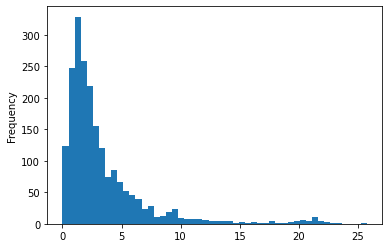

In [ ]:
dsSampleTrain[dsSampleTrain['distance'] < 1000]['distance'].plot(kind = 'hist', bins = 50)

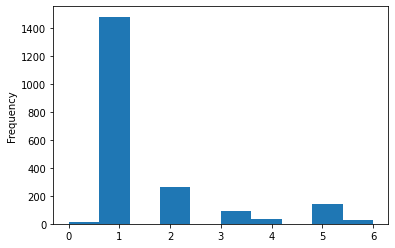

In [ ]:
dsSampleTrain['passenger_count'].plot(kind = 'hist')

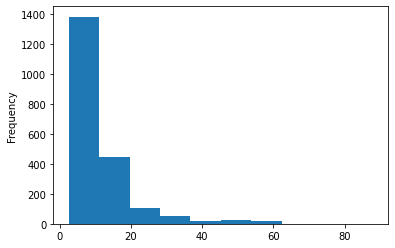

In [ ]:
dsSampleTrain['fare_amount'].plot(kind = 'hist')

# 5. References

https://www.kaggle.com/c/restaurant-revenue-prediction/overview

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

https://www.kaggle.com/c/favorita-grocery-sales-forecasting/overview

https://www.kaggle.com/c/ga-customer-revenue-prediction/overview

https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather/overview

https://www.genbeta.com/desarrollo/microsoft-nasa-lanzan-tres-cursos-para-ensenar-como-usar-python-machine-learning-misiones-espaciales